# <center>Time Series Analysis on Pune precipitation data from 1965 to 2002.</center>

## <center>Algorithm: Auto Regressive Integrated Moving Average model(ARIMA)</center>

### Import libraries

In [40]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

### Filename

In [41]:
filename = '/kaggle/input/pune-precipitation-dataset/pune_1965_to_2002.csv'

### Data
- Downloaded from http://www.indiawaterportal.org/met_data/
- State: Maharashtra
- District: PUNE
- Data type: Precipitation
- Data Range: Monthly mean precipitation for all the years from 1972 to 2002

In [42]:
rainfall_data_matrix = pd.read_csv(filename, delimiter='\t')
rainfall_data_matrix.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1,1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
2,1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
3,1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
4,1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951


<Axes: >

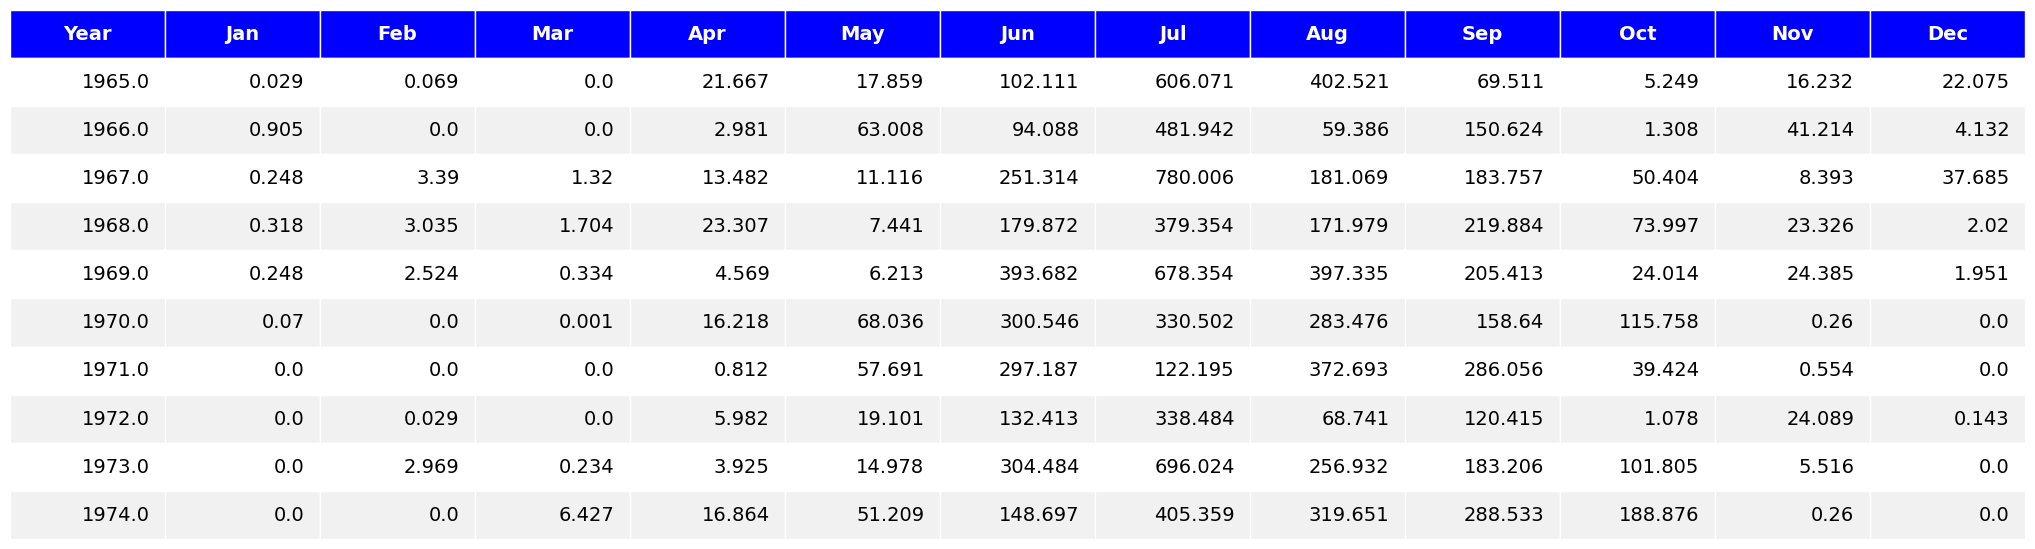

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#0000ff', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(rainfall_data_matrix.head(10).round(3), header_columns=0, col_width=2.0)

### Set 'Year' as index

In [44]:
rainfall_data_matrix.set_index('Year', inplace=True)
rainfall_data_matrix.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951


### Transpose data for easy visualiztion

In [45]:
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.029,0.905,0.248,0.318,0.248,0.070,0.000,0.000,0.000,0.000,...,0.000,0.879,0.695,0.016,1.284,0.008,0.000,0.000,0.147,0.231
Feb,0.069,0.000,3.390,3.035,2.524,0.000,0.000,0.029,2.969,0.000,...,0.078,0.325,0.000,2.779,0.000,2.671,1.431,0.170,0.000,0.911
Mar,0.000,0.000,1.320,1.704,0.334,0.001,0.000,0.000,0.234,6.427,...,1.211,2.415,1.770,0.087,0.747,0.073,0.000,0.000,2.178,0.388
Apr,21.667,2.981,13.482,23.307,4.569,16.218,0.812,5.982,3.925,16.864,...,2.062,16.823,25.949,6.318,23.912,0.377,0.642,1.193,1.528,53.266
May,17.859,63.008,11.116,7.441,6.213,68.036,57.691,19.101,14.978,51.209,...,3.248,33.378,23.964,5.134,4.664,15.717,35.828,26.237,7.860,18.430
Jun,102.111,94.088,251.314,179.872,393.682,300.546,297.187,132.413,304.484,148.697,...,234.068,749.030,163.515,453.607,673.831,238.609,415.471,371.328,247.982,509.145
Jul,606.071,481.942,780.006,379.354,678.354,330.502,122.195,338.484,696.024,405.359,...,450.088,707.986,501.461,558.586,422.913,590.663,277.137,265.417,279.547,84.936
Aug,402.521,59.386,181.069,171.979,397.335,283.476,372.693,68.741,256.932,319.651,...,150.278,230.898,114.206,212.489,541.579,362.357,98.616,220.814,189.404,257.205
Sep,69.511,150.624,183.757,219.884,205.413,158.640,286.056,120.415,183.206,288.533,...,101.928,115.509,288.262,203.642,60.477,243.444,225.962,147.196,158.025,78.269
Oct,5.249,1.308,50.404,73.997,24.014,115.758,39.424,1.078,101.805,188.876,...,225.904,116.348,84.359,176.471,31.050,96.324,180.300,38.246,135.518,21.486


<Axes: >

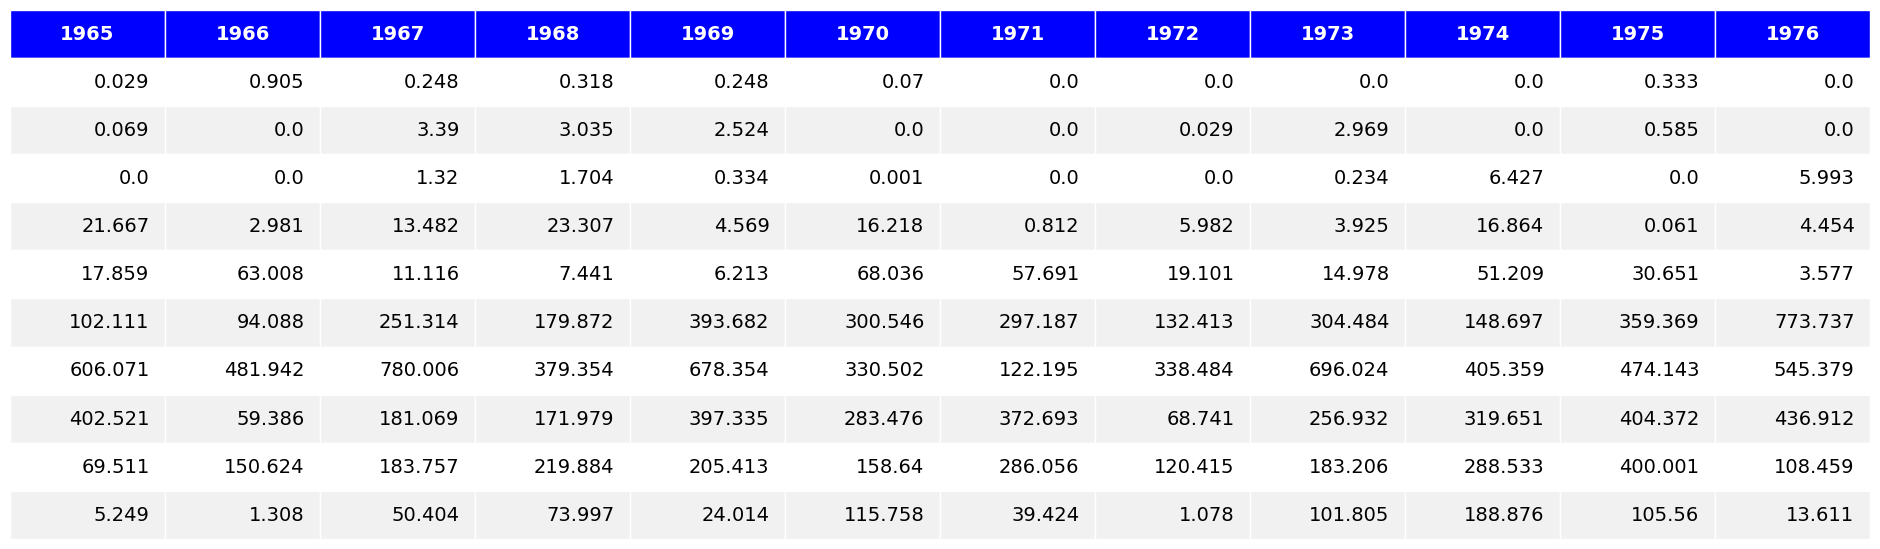

In [46]:
render_mpl_table(rainfall_data_matrix.iloc[:,0:12].head(10).round(3), header_columns=0, col_width=2.0)


### Genearete dates from 1965-01(January 1965) to 2002-12(December 2002)

In [47]:
dates = pd.date_range(start='1965-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')

### Visualize the whole data

Text(0.5, 1.0, 'Month vs mean precipitation across all years')

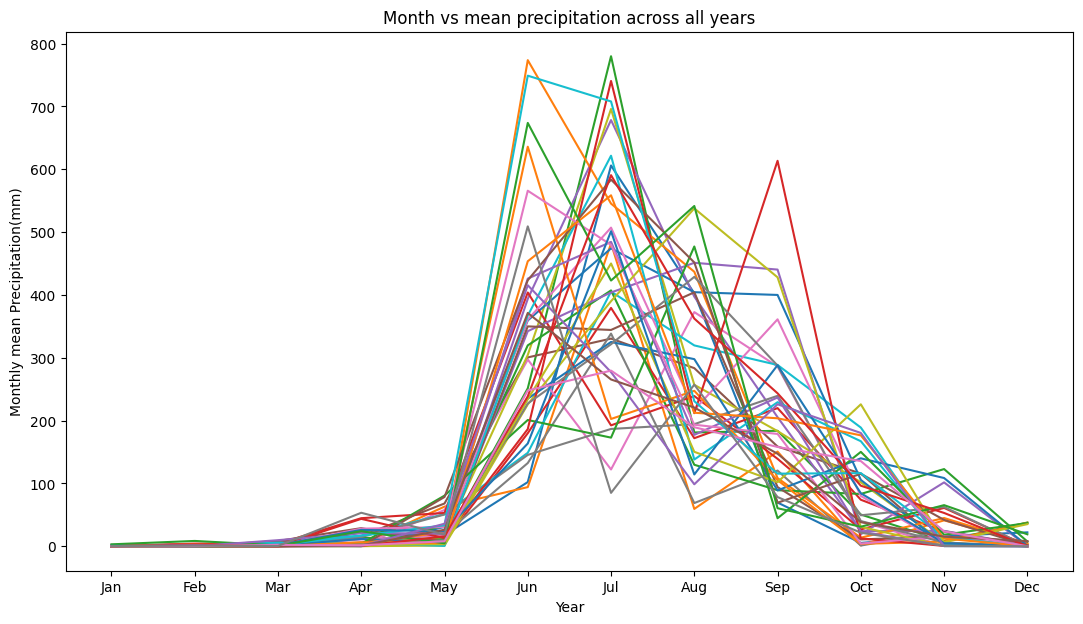

In [48]:
plt.figure(figsize=(13,7))
plt.plot(rainfall_data_matrix)
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Month vs mean precipitation across all years')

### Box plot
- Box plot helps us to understand the data better.

Text(0.5, 1.0, 'Month vs Precipitation across all years')

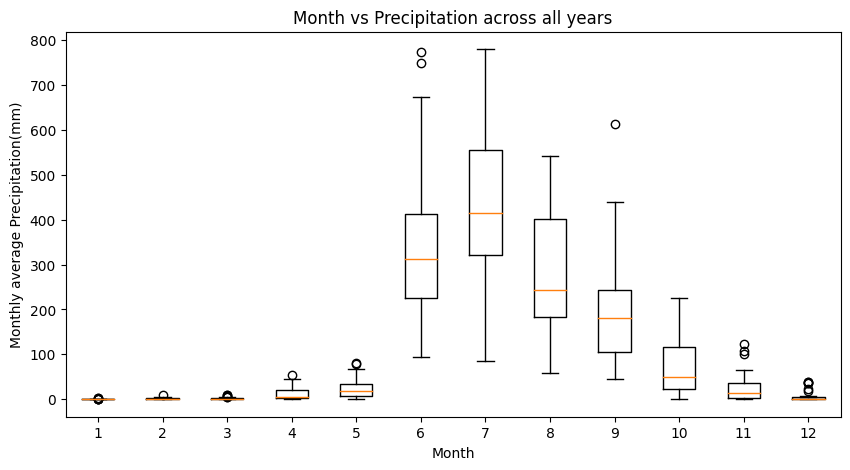

In [60]:
plt.figure(figsize=(10,5))
plt.boxplot(rainfall_data_matrix.T)
plt.xlabel('Month')
plt.ylabel('Monthly average Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

### Box plot for average rainfall across years

In [61]:
average_rainfall_year = pd.DataFrame({'average_rainfall_year': rainfall_data_matrix.mean(axis=0)})
average_rainfall_year = average_rainfall_year.transpose()
average_rainfall_year.head()

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
average_rainfall_year,105.282833,74.965667,126.848667,90.51975,144.9185,106.125583,98.051,59.20625,130.839417,118.823,...,100.854333,165.64075,100.755667,135.94425,153.736667,133.603583,102.973583,91.171833,87.152083,85.40675


Text(0.5, 1.0, 'Year vs Average Precipitation')

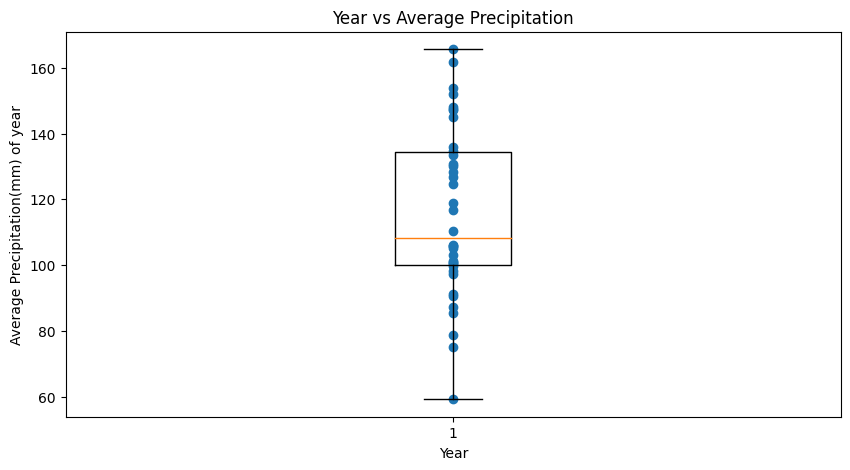

In [62]:
plt.figure(figsize=(10,5))
plt.boxplot(average_rainfall_year.T)
plt.scatter(x=[1] * len(average_rainfall_year.iloc[0]), y=average_rainfall_year.iloc[0])
plt.xlabel('Year')
plt.ylabel('Average Precipitation(mm) of year')
plt.title('Year vs Average Precipitation')

### Insights from the plot
- The rainfall in the months November, December, January, February, March and April is very less.
- The rainfall in the months June, July and August are high compared to rainfall in other months of the year. 
- We can observe the seasonality effect.

### Convert matrix into Series

In [79]:
rainfall_data_matrix_np = rainfall_data_matrix.transpose().values

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

### Split the whole data into train(1965 - 1995) and test data(1995 - 2002)

In [85]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
dates = pd.date_range(start='1965-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
rainfall_data.set_index(dates, inplace=True)

test_rainfall_data = rainfall_data.loc['1995': '2002']
rainfall_data = rainfall_data.loc[: '1994']
rainfall_data.head()

,Precipitation
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


### Visualize data

Text(0.5, 1.0, 'Monthly mean Precipitation(mm) across years')

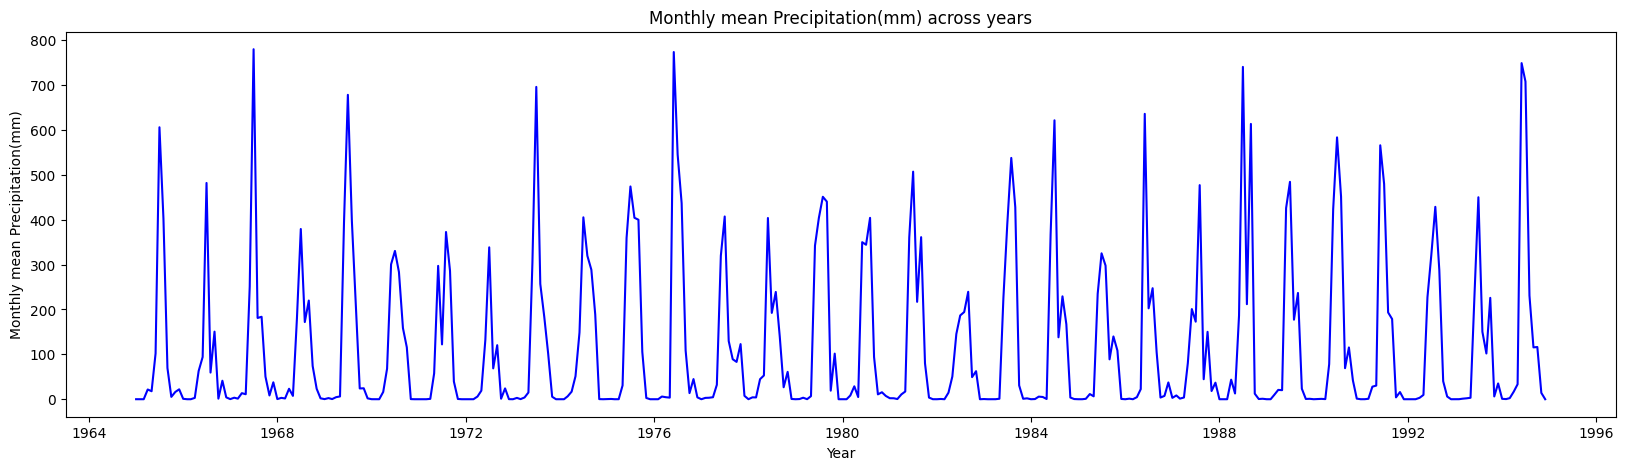

In [86]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Monthly mean Precipitation(mm) across years')

### Visualize data(zoomed version) - 5 years(1972 - 1977)

Text(0.5, 1.0, 'Monthly mean Precipitation(mm) across years')

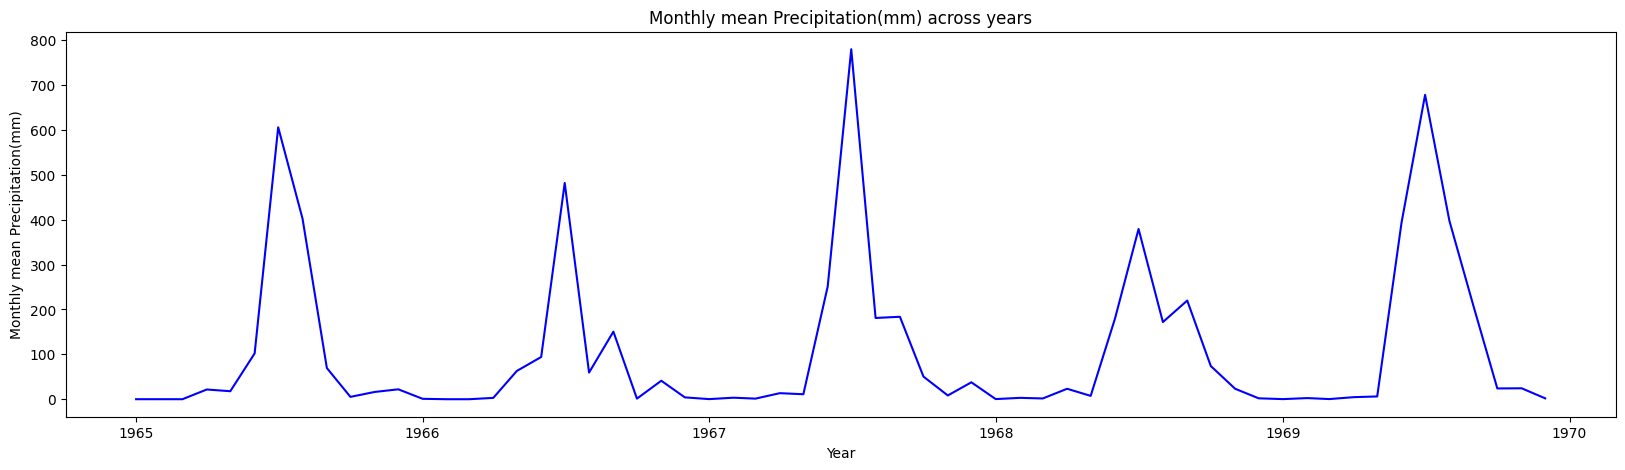

In [89]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data.iloc[:60], color='blue')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation(mm)')
plt.title('Monthly mean Precipitation(mm) across years')

### To decipher underlying patterns we must decompose the series.

In [90]:
decomposition = sm.tsa.seasonal_decompose(rainfall_data, model='additive')

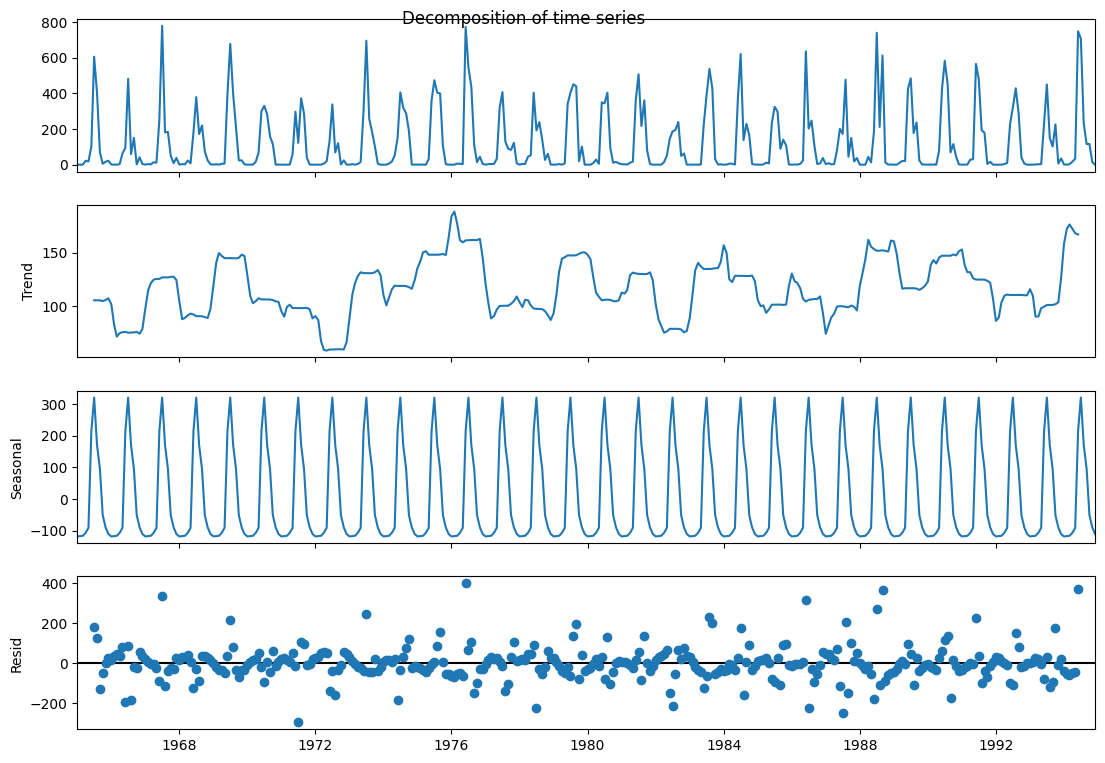

In [91]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of time series')
plt.show()

### Moving Average - Find window or seasonality time period "s"

**Moving Average** - The idea with moving average is to remove all the zigzag motion from the time series to produce a steady trend through averaging adjacent values of a time period.

Now, let’s try to remove zigzag motion from our time series using moving average. We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

### 4- Months Moving Average

Text(0.5, 1.0, '4 Months Moving Average')

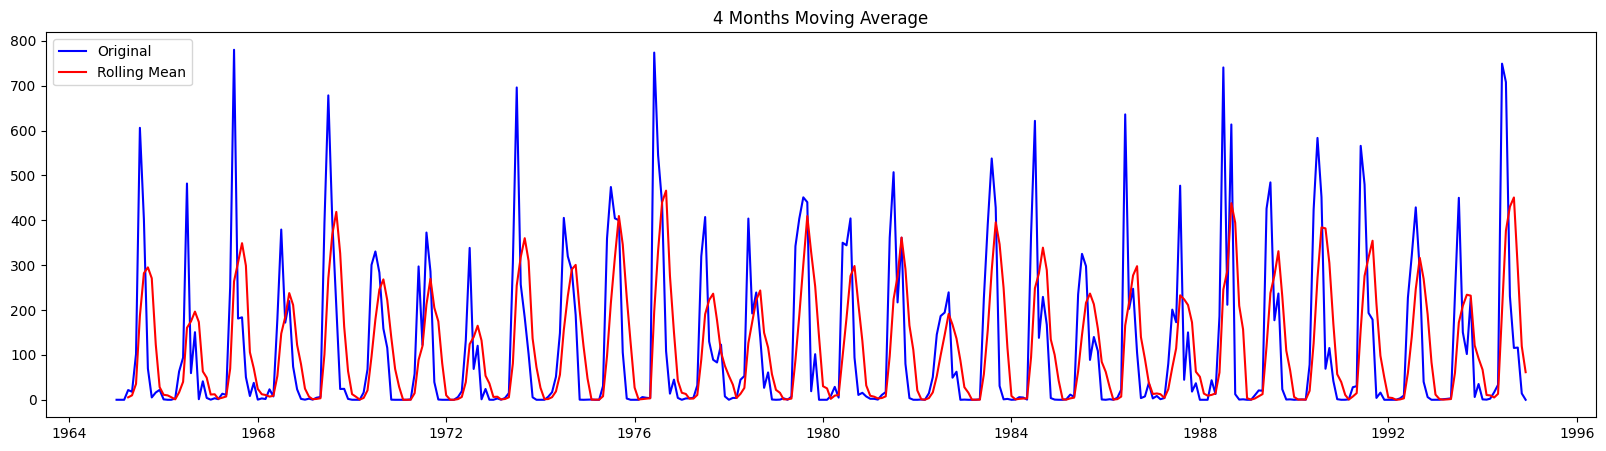

In [92]:
plt.figure(figsize=(20,5))
four_months_moving_average = rainfall_data.rolling(window=4).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(four_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('4 Months Moving Average')

### 6-Months Moving Average

Text(0.5, 1.0, '6 Months Moving Average')

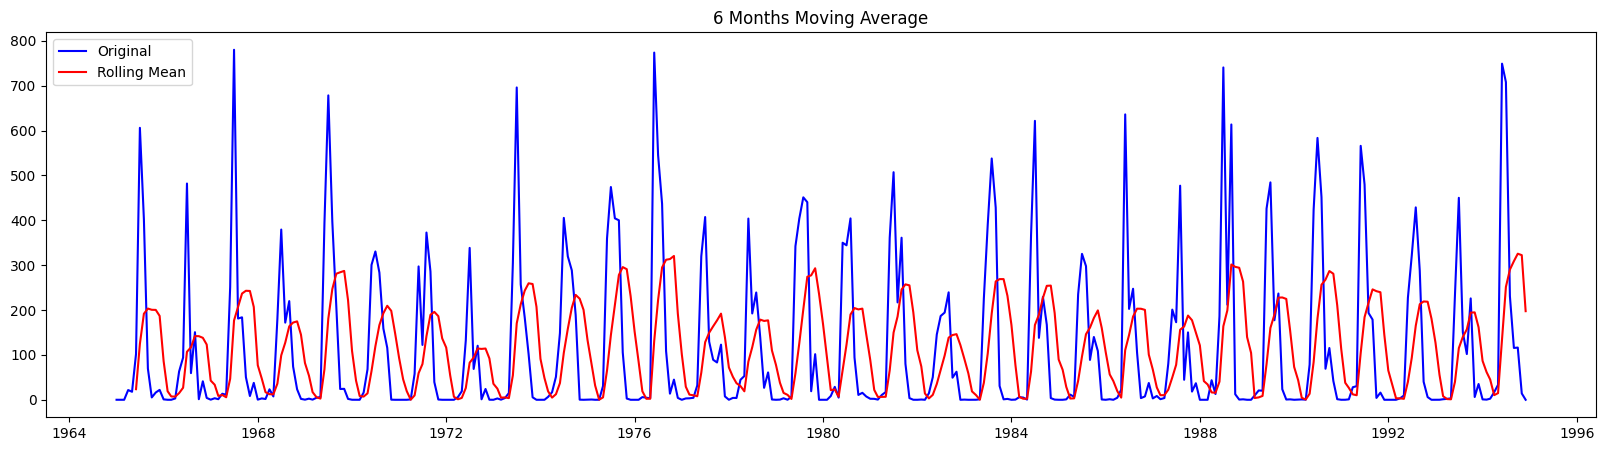

In [93]:
plt.figure(figsize=(20,5))
six_months_moving_average = rainfall_data.rolling(window=6).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(six_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('6 Months Moving Average')

### 8-Months Moving Average

Text(0.5, 1.0, '8 Months Moving Average')

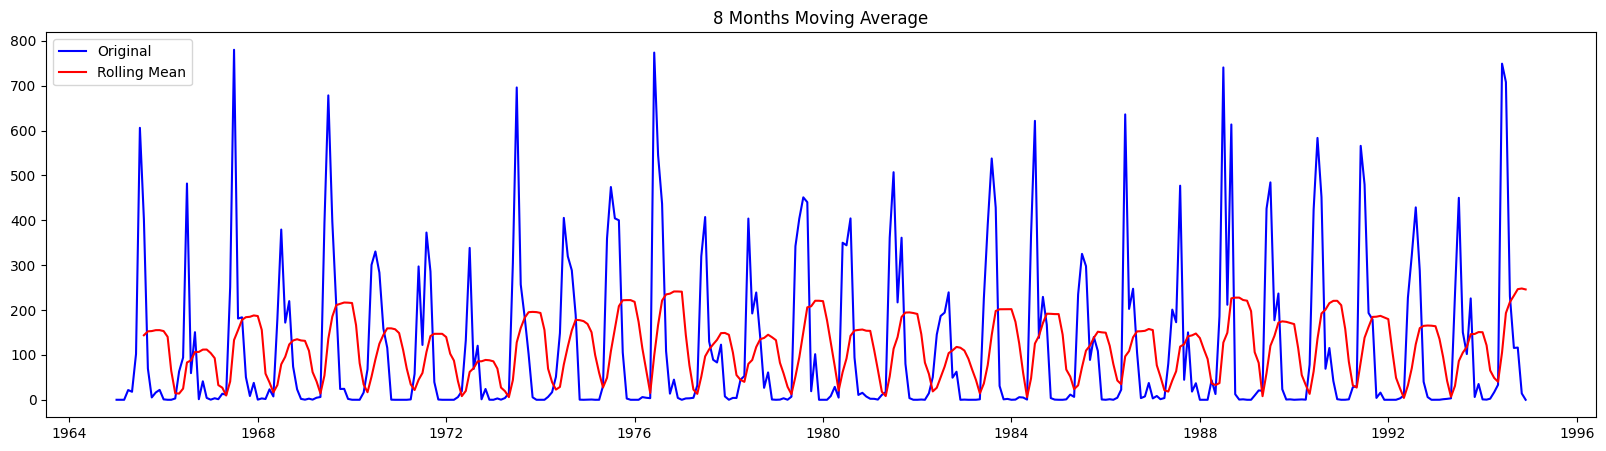

In [94]:
plt.figure(figsize=(20,5))
eight_months_moving_average = rainfall_data.rolling(window=8).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(eight_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('8 Months Moving Average')

### 12-Months Moving Average

Text(0.5, 1.0, '12 Months Moving Average')

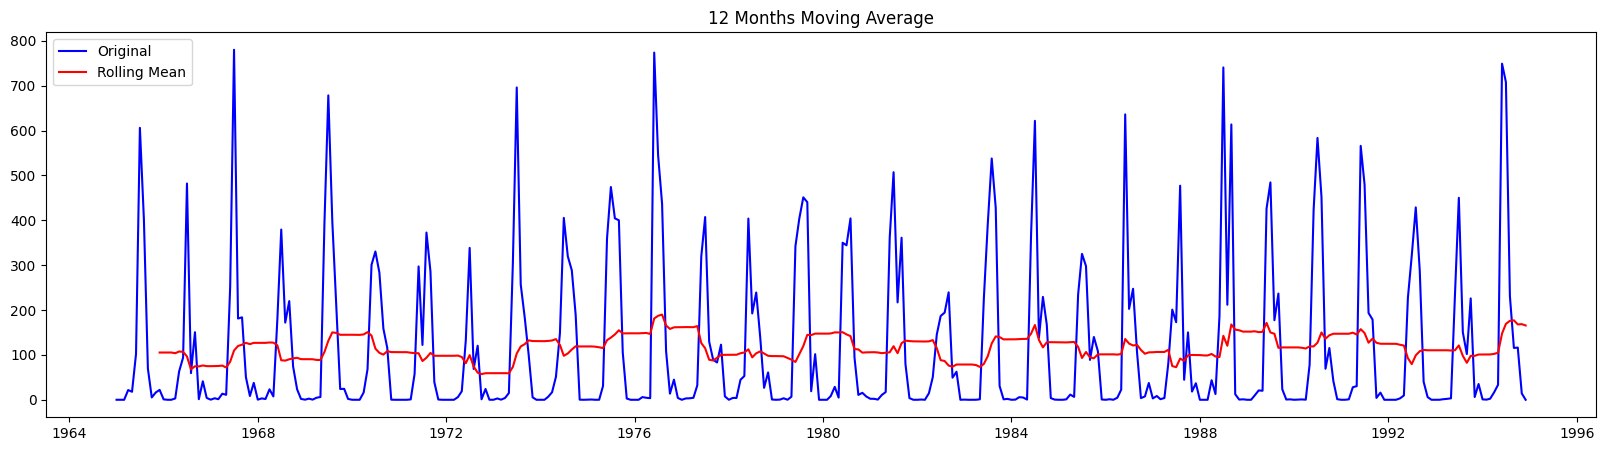

In [95]:
plt.figure(figsize=(20,5))
twelve_months_moving_average = rainfall_data.rolling(window=12).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(twelve_months_moving_average, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('12 Months Moving Average')

### Analysis of above plots
- As we could see in the above plots, 12-month moving average could produce a wrinkle free curve when compared to other moving averages.
- Therefore, s=12.

- This is to find the period of seasonality.

### Stationarity:
- A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- The basic assumption before applying different models like ARIMA is that the time series should be stationary.

### How to formally check stationarity?
- There are two tests to check whether a time series is stationary or not.
    - **Rolling statistics (Visual test)** - We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
    - **Dickey Fuller test** - This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a **Test Statistic** and some **Critical Values** for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

**Let's write a function to plot and check both tests at a time.**

In [96]:
def test_stationary(timeseries, window=12):
    
    # Rolling statistics
    movingAverage = timeseries.rolling(window=window).mean()
    movingSTD = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(20,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation\n')
    plt.show(block=False)
    
    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    dftest = adfuller(timeseries['Precipitation'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

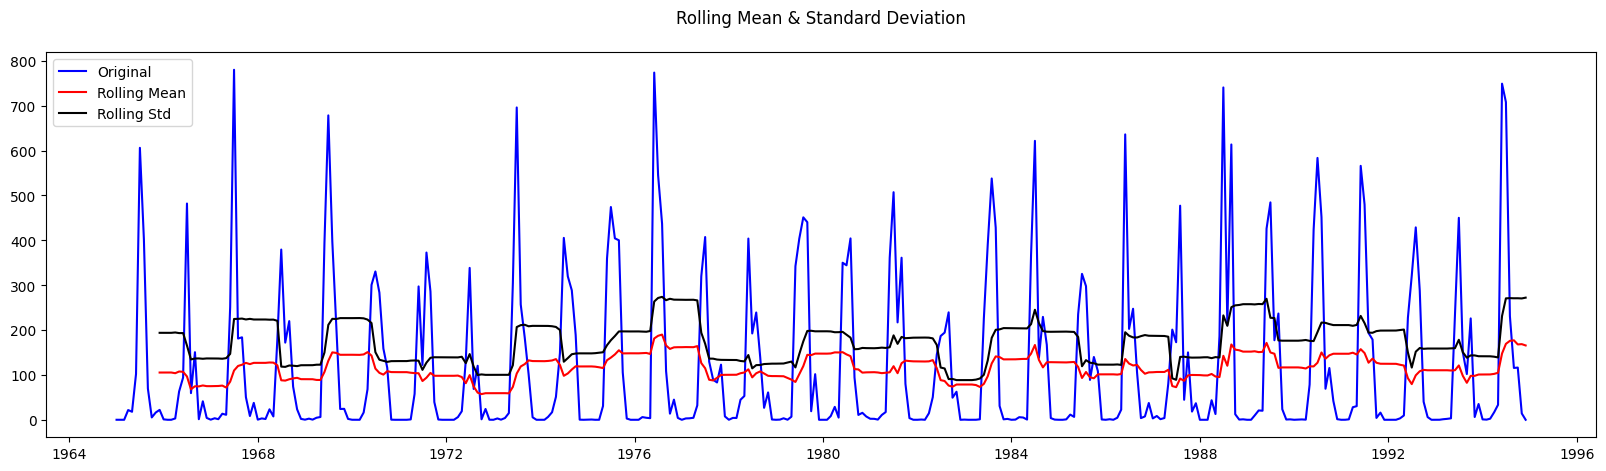

Results of Dickey Fuller Test:

Test Statistic                  -4.258992
p-value                          0.000523
No. of Lags used                11.000000
Number of observations used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


In [97]:
test_stationary(rainfall_data, window=12)

### Analysis
- As we could see, p-value is very less. Also, "Test statistic" is less compared to "Critical Value".
- Therefore, Null hypothesis is rejected, which means, Time series is stationary.

### Next steps:
- As time series is stationary, differencing is not required.
- Now, we have to find p and q values by plotting ACF and PACF plots.

### ACF and PACF plots

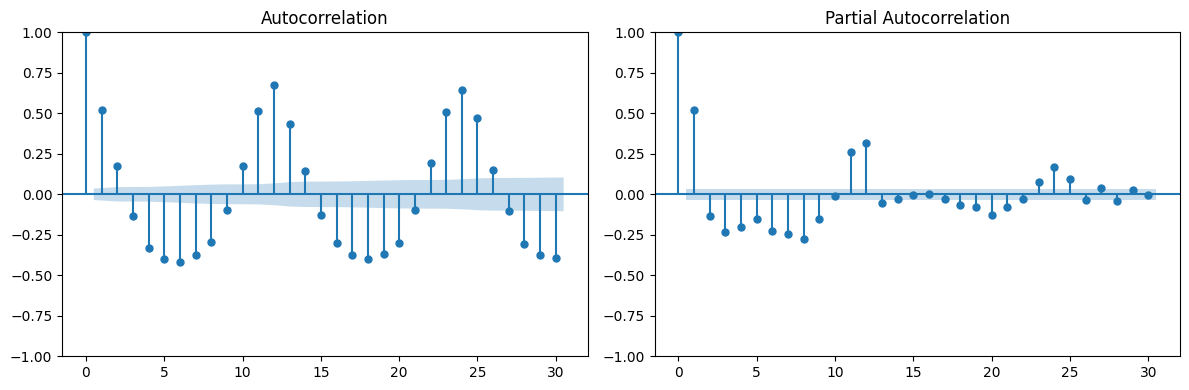

In [98]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(rainfall_data, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(rainfall_data, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

- As we could see, there is seasonality effect.

### Apply Differencing D = 1

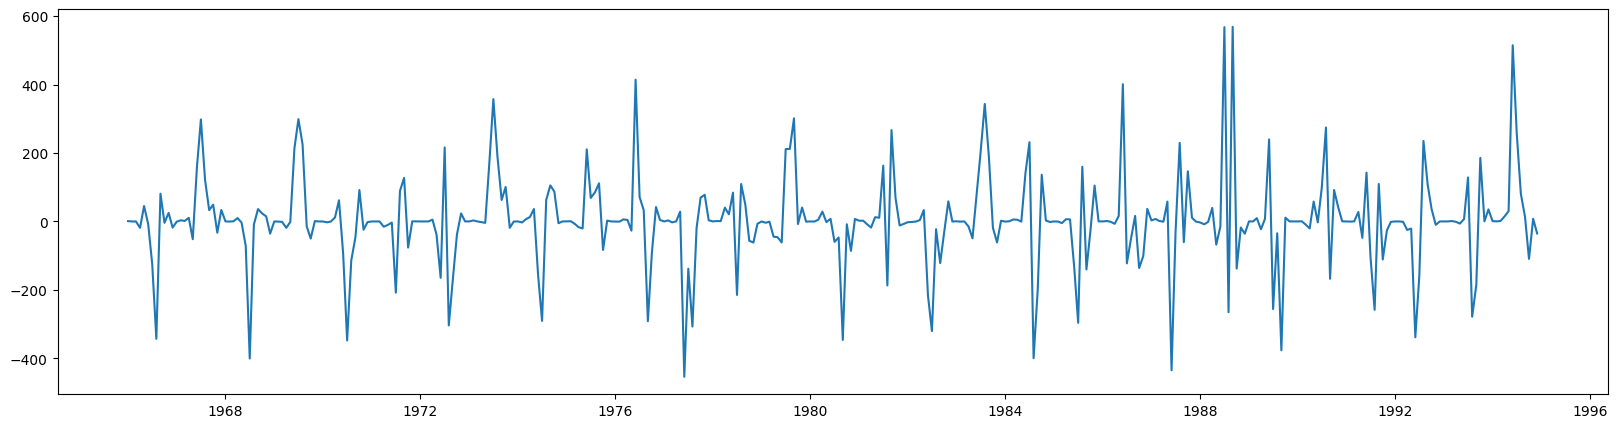

In [99]:
diff_12 = rainfall_data.diff(periods=12)
diff_12.dropna(inplace=True)

plt.figure(figsize=(20,5))
plt.plot(diff_12)

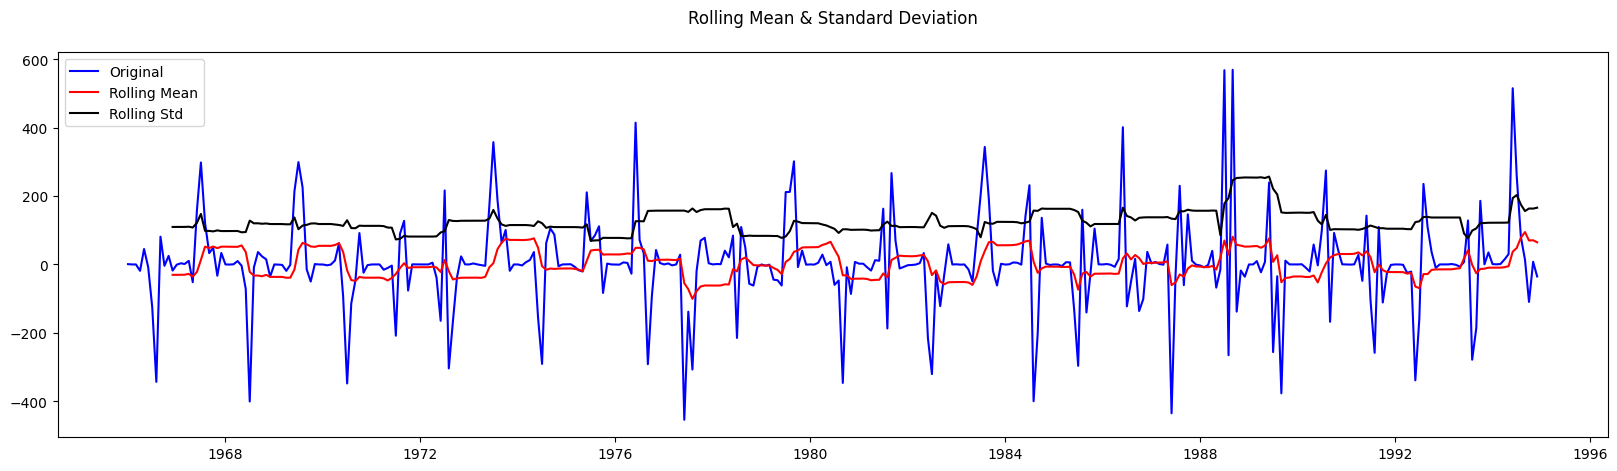

Results of Dickey Fuller Test:

Test Statistic                -8.550885e+00
p-value                        9.230261e-14
No. of Lags used               1.200000e+01
Number of observations used    3.350000e+02
Critical Value (1%)           -3.450022e+00
Critical Value (5%)           -2.870207e+00
Critical Value (10%)          -2.571387e+00
dtype: float64


In [100]:
test_stationary(diff_12)

- If there is seasonality, it will be better if we try all combinations of different parameters and choose the best set ofparameters that gives less AIC score.

### Parameters - p, d, q, P, D, Q
- Let's try all possible parameters and choose the best set of parameters that gives less AIC score.

In [102]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [103]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [104]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [106]:
AIC_scores_list = []

In [111]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:        
        try:
            
            temp_model = sm.tsa.statespace.SARIMAX(rainfall_data,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit(disp=False)
            l = []
            l.append(param[0])
            l.append(param[1])
            l.append(param[2])
            l.append(param_seasonal[0])
            l.append(param_seasonal[1])
            l.append(param_seasonal[2])
            l.append(param_seasonal[3])
            l.append(results.aic)
            AIC_scores_list.append(l)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:4182.508226011611


In [112]:
AIC_scores = pd.DataFrame.from_records(AIC_scores_list)
AIC_scores.columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'AIC']
AIC_scores.iloc[AIC_scores['AIC'].argmin()]

p                0
d                1
q              1.0
P              0.0
D              1.0
Q              1.0
s             12.0
AIC    4182.508226
Name: 91, dtype: object

<Axes: >

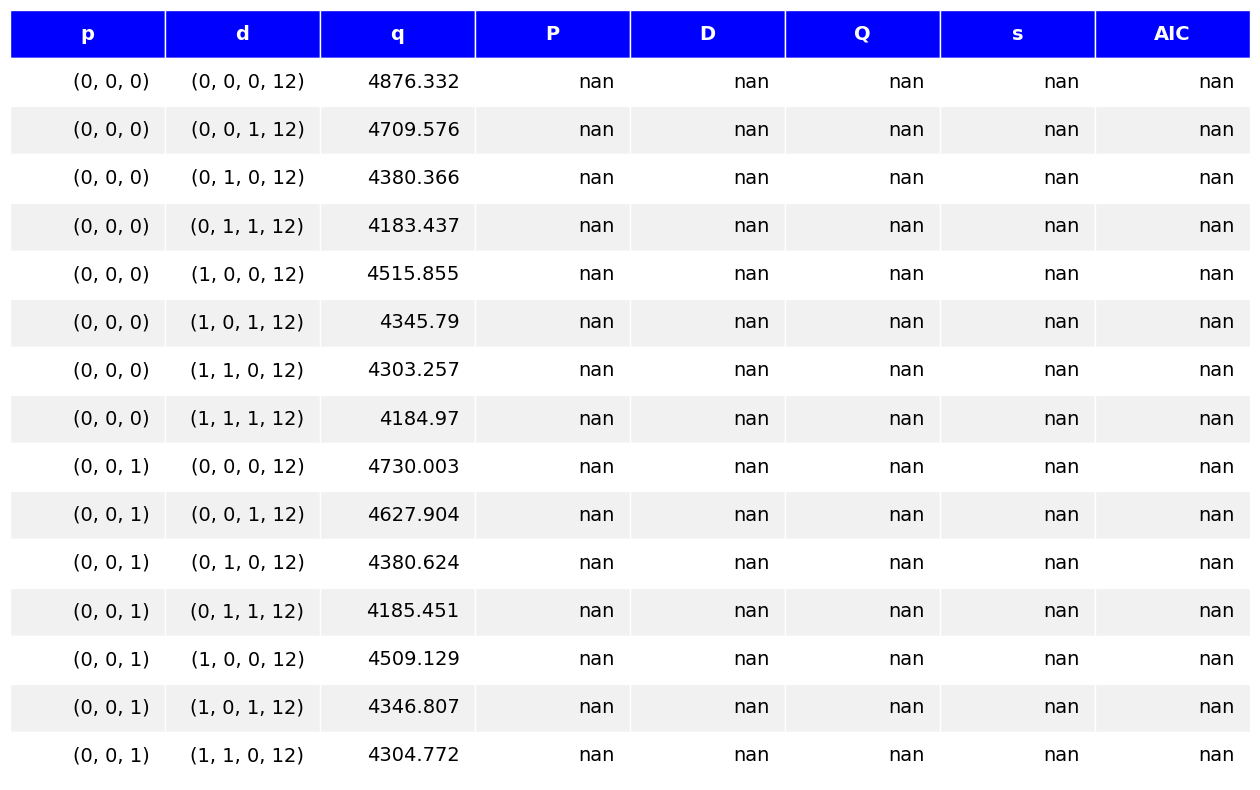

In [120]:
AIC_scores.head(15)
render_mpl_table(AIC_scores.head(15).round(3), header_columns=0, col_width=2.0)

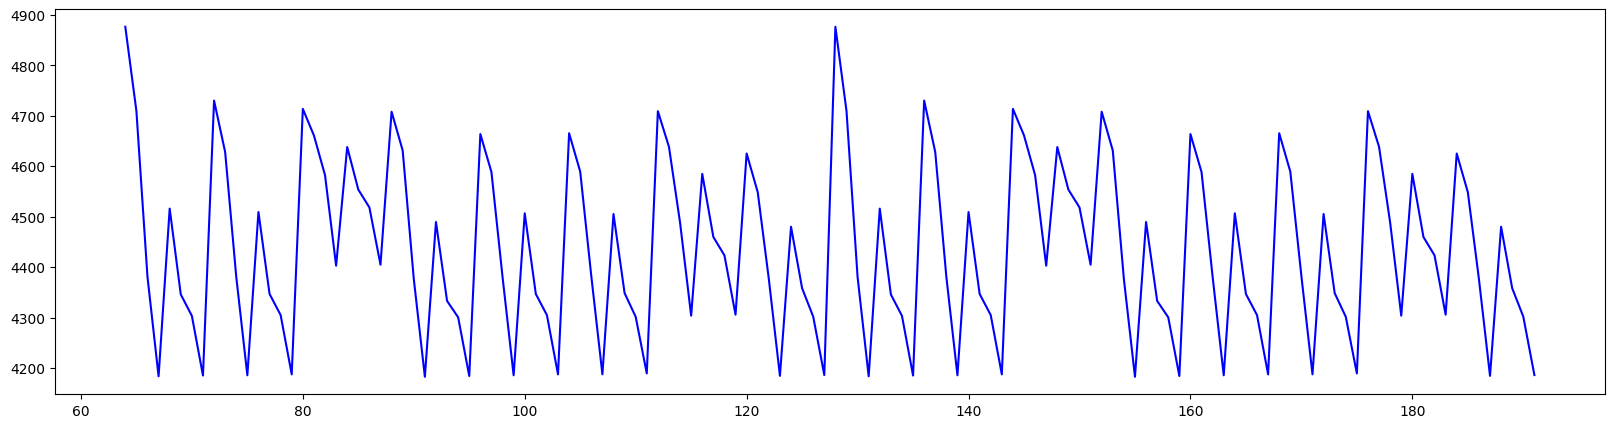

In [121]:
plt.figure(figsize=(20,5))
plt.plot(AIC_scores.AIC, color='blue')
plt.plot(27, AIC_scores.AIC[27], 'r*')

### Analysis:
- After fitting the data with different combination of models, we got the best parameters as following:
    - p = 0, d = 1, q = 1
    - P = 0, D = 1, Q = 1
    - s = 12

In [122]:
best_pdq = (0, 1, 1)
best_seasonal_pdq = (0, 1, 1, 12)

### Use the best parameters and build a model

In [125]:
best_model = sm.tsa.statespace.SARIMAX(rainfall_data,
                                      order=best_pdq,
                                      seasonal_order=best_seasonal_pdq,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit(disp=False)

In [126]:
print(best_results.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                      Precipitation   No. Observations:                  360
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2088.254
Date:                            Sun, 09 Jun 2024   AIC                           4182.508
Time:                                    15:38:57   BIC                           4194.056
Sample:                                01-01-1965   HQIC                          4187.106
                                     - 12-01-1994                                         
Covariance Type:                              opg                                         


### Get predictions 

In [127]:
pd.to_datetime('1990-01-01')

Timestamp('1990-01-01 00:00:00')

In [129]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

### Extract the predicted and true values of our time series

In [130]:
rainfall_predicted = pred_dynamic.predicted_mean
rainfall_truth = rainfall_data['1990':].Precipitation

### Compute the mean square error

In [131]:
mse = math.sqrt(((rainfall_predicted - rainfall_truth) ** 2).mean())
print('The Mean Squared Error of our predictions is {}'.format(round(mse, 4)))

The Mean Squared Error of our predictions is 97.6637


In [132]:
rainfall_data.index[-1]

Timestamp('1994-12-01 00:00:00')

### Visuaization of true and predicted values

In [133]:
rainfall_dummy_data = rainfall_data
rainfall_dummy_data.columns = ['Train data']

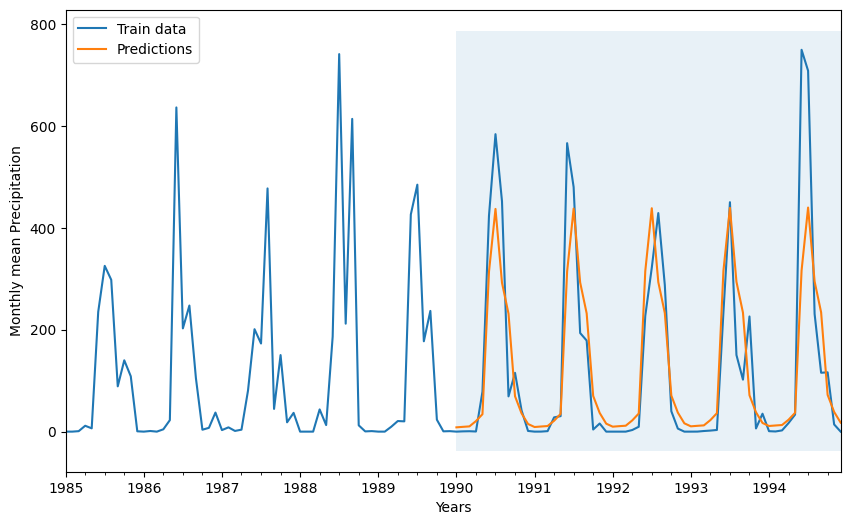

In [134]:
# Plot the actual values.
axis_plt = rainfall_dummy_data['1985':].plot(label='Train data', figsize=(10, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Predictions')

# Plot confidence values and fill it with some colour.
# axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('1990'), rainfall_data.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')

### Forecast
- Predict Precipitation for next 7 years.

In [135]:
# Get forecast 96 steps (8 years) ahead in future
n_steps = 96
pred_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% of the forecasts
pred_ci_95 = pred_uc_95.conf_int()

In [140]:
from pandas.tseries.offsets import DateOffset

index = pd.date_range(rainfall_data.index[-1] + DateOffset(months=1), periods=n_steps, freq='MS')
forecast_data = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=index, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

forecast_data.head()

,forecast,lower_ci_95,upper_ci_95
1995-01-01,11.753373,-173.843266,197.350012
1995-02-01,12.528714,-173.067968,198.125396
1995-03-01,13.425737,-172.170966,199.022439
1995-04-01,23.487717,-162.109005,209.084440
1995-05-01,38.512348,-147.084395,224.109091


### Plot the forecast along with confidence band

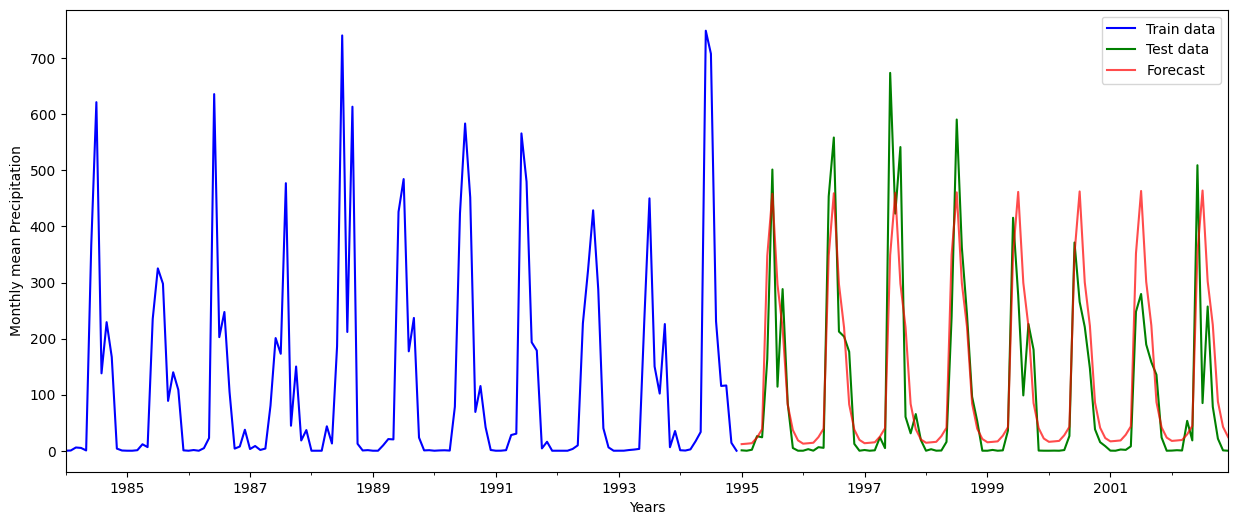

In [141]:
axis_plt = rainfall_dummy_data['1984':].plot(label='Observed', color='blue', figsize=(15, 6))

test_rainfall_data.Precipitation.plot(ax=axis_plt, color='green', label='Test data')
forecast_data['forecast'].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

# axis_plt.fill_between(forecast_data.index, forecast_data['lower_ci_95'], forecast_data['upper_ci_95'], color='k', alpha=.25)

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [142]:
dummy_test_data = test_rainfall_data
dummy_test_data.columns = ['Test data']

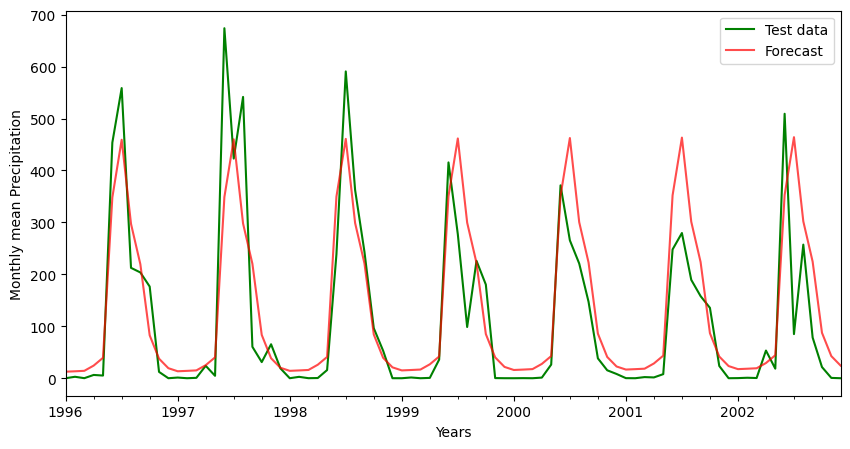

In [143]:
axis_plt = dummy_test_data['1996':].plot(label='Actual values', figsize=(10, 5), color='green')
forecast_data['forecast']['1996':].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

### Mean square error of the forecasts

In [144]:
y_true = test_rainfall_data['1995-01-01':]['Test data']
y_forecast = forecast_data['forecast']

In [146]:
mse = math.sqrt(((y_true - y_forecast) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 89.2525


### MAPE

In [147]:
mape = np.mean(np.abs((y_true - y_forecast) / (y_true))) * 100
print('The MAPE of our forecasts is {}'.format(round(mape, 4)))

The MAPE of our forecasts is inf


In [148]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [149]:
mape_vectorized_v2(y_true, y_forecast)

158.0002218207956

In [150]:
RMSE_data = [['Train RMSE', 97.66, 74.58],
            ['Test RMSE', 89.25, 91.69]]

In [151]:
RMSE_data_df = pd.DataFrame.from_records(RMSE_data)
RMSE_data_df.columns = ['Type of Data', 'RMSE of ARIMA', 'RMSE of LSTM']
RMSE_data_df

,Type of Data,RMSE of ARIMA,RMSE of LSTM
0,Train RMSE,97.66,74.58
1,Test RMSE,89.25,91.69


Text(0.5, 1.0, 'ARIMA - Train and Test RMSE')

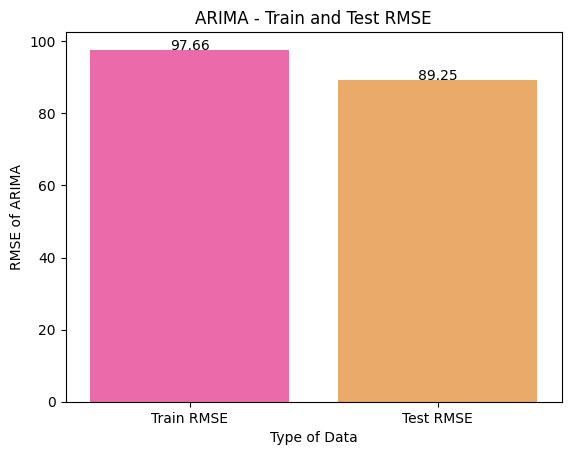

In [152]:
g = sns.barplot(x='Type of Data', y='RMSE of ARIMA', data=RMSE_data_df, palette='spring')
for index, row in RMSE_data_df.iterrows():
    g.text(row.name, row['RMSE of ARIMA'], round(row['RMSE of ARIMA'],2), color='black', ha="center")
plt.title('ARIMA - Train and Test RMSE')